# SSK4409 Project Part 2 - Data Analytics
- Let's forecast typhoon's future like movement, wind speed, pressure, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# i. Pre-processing, data cleaning
For this part, we will be doing the basic data processing and data cleaning.

In [ ]:
data = pd.read_csv("/kaggle/input/asian-typhoon-dataset-1951-2022-rsmc-best-track/typhoon_data.csv", index_col=0)
data.head()

,International number ID,year,month,day,hour,grade,Latitude of the center,Longitude of the center,Central pressure,Maximum sustained wind speed,Direction of the longest radius of 50kt winds or greater,The longeast radius of 50kt winds or greater,The shortest radius of 50kt winds or greater,Direction of the longest radius of 30kt winds or greater,The longeast radius of 30kt winds or greater,The shortest radius of 30kt winds or greater,Indicator of landfall or passage
0,5101,1951,2,19,6,Tropical Depression,200,1385,1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,5101,1951,2,19,12,Tropical Depression,200,1385,1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,5101,1951,2,19,18,Tropical Depression,230,1421,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,5101,1951,2,20,0,Tropical Cyclone of TS intensity or higher,250,1460,994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,5101,1951,2,20,6,Tropical Cyclone of TS intensity or higher,276,1506,994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [ ]:
# scale values and drops unnecessary columns
data["Latitude of the center"] /= 10
data["Longitude of the center"] /= 10
data = data.drop(["Indicator of landfall or passage"], axis=1)

In [ ]:
# Drop rows before year 1977 because they used different method to grade and record typhoons
data = data[data["year"] >= 1977]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43356 entries, 25268 to 68623
Data columns (total 16 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   International number ID                                   43356 non-null  int64  
 1   year                                                      43356 non-null  int64  
 2   month                                                     43356 non-null  int64  
 3   day                                                       43356 non-null  int64  
 4   hour                                                      43356 non-null  int64  
 5   grade                                                     43356 non-null  object 
 6   Latitude of the center                                    43356 non-null  float64
 7   Longitude of the center                                   43356 non-null  float64
 8   Central pres

## Dealing with "Just Entered" grade.
- There is no grade for just entered TDs.
- Since there are only 28 those just entered rows, and They are first head of the TD datas...
- Let's just Drop them for this time.

In [ ]:
idx = data["grade"]=="Just entering into the responsible area of RSMC Tokyo-Typhoon Center"
data[idx].shape

(28, 16)

In [ ]:
data = data.drop(data[idx].index)
data.shape

(43328, 16)

## Other things to Cleaning Data

In [ ]:
data["grade"].unique()

array(['Tropical Depression', 'Severe Tropical Storm', 'Tropical Storm',
       'Extra-tropical Cyclone', 'Typhoon'], dtype=object)

In [ ]:
data = data.replace("Tropical Depression", "TD")
data = data.replace("Severe Tropical Storm", "STS")
data = data.replace("Tropical Storm", "TS")
data = data.replace("Extra-tropical Cyclone", "L")
data = data.replace("Typhoon", "TY")

# Drop the rows that is not typhoon.
- We want to predict(forecast) typhoons movement and size, directions like that.
- So we don't need minor informations of Tropical Depressions and Cyclones.

In [ ]:
data[data["Direction of the longest radius of 50kt winds or greater"].isna()]["grade"].unique()
data[data["Direction of the longest radius of 50kt winds or greater"].notna()]["grade"].unique()

array(['STS', 'TS', 'TY'], dtype=object)

In [ ]:
data = data.dropna()

# Data Vectorization

In [ ]:
data = data.drop(["Direction of the longest radius of 50kt winds or greater", "Direction of the longest radius of 30kt winds or greater"], axis=1)

In [ ]:
grade_map = {"TD":1, "TS":2, "STS":3, "TY":4}  # I made grade map using the starndard for grade Tropical Depressions of WMO
data["grade"] = data["grade"].map(grade_map)

## Generalize measured time of data
- Most of our data is measured in every 6 hours.
- But some of our data is measured in 3 hours after the previous measure.
- So I will drop every 3 hour interval rows for simplify our task.

In [ ]:
data = data[data["hour"] % 6 == 0]

# Grouping data rows by each typhoons

In [ ]:
data.head()

,International number ID,year,month,day,hour,grade,Latitude of the center,Longitude of the center,Central pressure,Maximum sustained wind speed,The longeast radius of 50kt winds or greater,The shortest radius of 50kt winds or greater,The longeast radius of 30kt winds or greater,The shortest radius of 30kt winds or greater
25272,7701,1977,3,28,0,3,5.6,158.8,990,50.0,0.0,0.0,125.0,125.0
25273,7701,1977,3,28,6,3,6.1,158.2,996,50.0,0.0,0.0,125.0,125.0
25274,7701,1977,3,28,12,3,6.6,157.5,1000,50.0,0.0,0.0,125.0,125.0
25275,7701,1977,3,28,18,2,7.0,156.8,1002,45.0,0.0,0.0,100.0,100.0
25276,7701,1977,3,29,0,2,7.3,156.0,1002,45.0,0.0,0.0,100.0,100.0


In [ ]:
ids = data["International number ID"].unique() # Unique IDs of typhoons
typhoons = list()
for ID in ids:
    typhoon = data[data["International number ID"] == ID]
    typhoon = typhoon.drop(["International number ID"], axis=1)
    typhoons.append(typhoon)
print(len(typhoons))

1174


# How many data do we have?
- Quantity of data is different by each typhoon.
- Let's check a histogram.

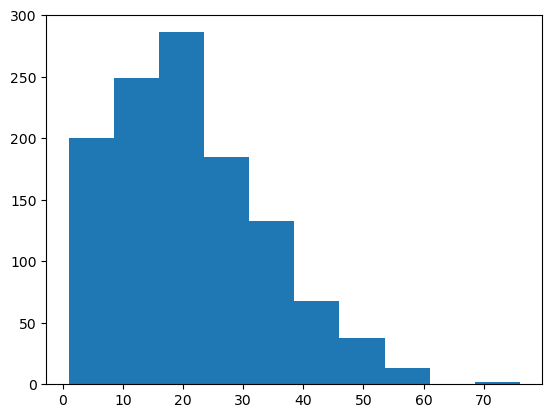

[200. 249. 286. 185. 133.  68.  38.  13.   0.   2.]


In [ ]:
hist = data["International number ID"].value_counts()
n = plt.hist(hist)
plt.show()
print(n[0])

- Luckily, more than 75% of typhoons contains >10 rows.

# Make Dataset for ML
- Let's Define our task.
- We're going to predict the typhoon's future state using the typhoon's previous state.
- Than how much previous state datas are we gonna use?
  - Basically, There are 6 hours interval between each row.
  - But in some case, There are 3 hours interval.
  - So using previous state of 3 hours ago is our best option. But there is a lack of data.
  - Let's try to use 6 hours ago data for this time.

## summary
- We're gonna predict typhoon's state of 6 hours later with state of current typhoon and 6 hours previous state of typhoon.
- We'll predict the state of typhoon below.
  - Location(latitude and longitude) of the center, Central Pressure, wind speed, radius of 50kt/30kt winds or greater.

In [ ]:
interval = 1
dataset = np.empty((0, 3, 13))
test_typhoons = np.empty((0,3,13))  # Preserve Some typhoons for model evaluation

for typhoon in typhoons:
    nptyphoon = np.array(typhoon)
    for i in range(0, nptyphoon.shape[0]-3, interval):
        single_data = nptyphoon[i:i+3]
        single_data = np.expand_dims(single_data, axis=0)
        if typhoon.iloc[0]["year"]==2022:
            test_typhoons = np.append(test_typhoons, single_data, axis=0)
            continue
        dataset = np.append(dataset, single_data, axis=0)
print(dataset.shape)
print(test_typhoons.shape)

(20778, 3, 13)
(297, 3, 13)


# ii. Modelling

In [ ]:
# X, Y split
x = dataset[:, :2, :]
y = dataset[:, 2, 5:] # we don't predict year, month, day, hour, and grade

# Train, Test split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(14544, 2, 13)
(14544, 8)
(6234, 2, 13)
(6234, 8)


In [ ]:
# Flatten X data
x_train = x_train.reshape(-1, 26)
x_val = x_val.reshape(-1, 26)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

x_train = scale.fit_transform(x_train)
x_val = scale.transform(x_val)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_train)
rmse = mean_squared_error(pred, y_train, squared=False)

print("Training Score:", rmse)

pred = lr.predict(x_val)
rmse = mean_squared_error(pred, y_val, squared=False)
print("Test Score:", rmse)

Training Score: 10.686176285554538
Test Score: 10.78454339830996


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_train)
rmse = mean_squared_error(pred, y_train, squared=False)

print("Training Score:", rmse)

pred = rf.predict(x_val)
rmse = mean_squared_error(pred, y_val, squared=False)
print("Test Score:", rmse)

Training Score: 4.655965608421148
Test Score: 12.517143272553808


## Deep Neural Network (MLP)

In [ ]:
import torch
from torch import nn
import random

random.seed(42)
torch.manual_seed(42)

x_train_t = torch.tensor(x_train, dtype=torch.float)
x_val_t = torch.tensor(x_val, dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)
y_val_t = torch.tensor(y_val, dtype=torch.float)

In [ ]:
batch_size=100
training_epochs=15
learning_rate=0.001

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_train_t, y_train_t),
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

In [ ]:
model = nn.Sequential(nn.Linear(x_train_t.shape[1], 10),
                      nn.ReLU(inplace=True),
                      nn.Linear(10, y_train_t.shape[1]))

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(1, training_epochs+1):
    avg_cost = 0
    total_batch = len(data_loader)

    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        hypothesis = model(x_batch)
        cost = criterion(hypothesis, y_batch)
        cost.backward()
        optimizer.step()

        avg_cost += cost
    avg_cost /= total_batch
    if epoch%10 == 0 or True:
        print("Epoch:", epoch, "cost:", avg_cost.item())

Epoch: 1 cost: 17121.82421875
Epoch: 2 cost: 723.2607421875
Epoch: 3 cost: 588.813720703125
Epoch: 4 cost: 513.271728515625
Epoch: 5 cost: 477.1266174316406
Epoch: 6 cost: 446.0960388183594
Epoch: 7 cost: 397.3575134277344
Epoch: 8 cost: 348.381591796875
Epoch: 9 cost: 320.035888671875
Epoch: 10 cost: 315.9840393066406
Epoch: 11 cost: 285.3972473144531
Epoch: 12 cost: 269.09588623046875
Epoch: 13 cost: 257.46771240234375
Epoch: 14 cost: 255.88619995117188
Epoch: 15 cost: 244.55560302734375


In [ ]:
model.eval()
with torch.no_grad():
    pred = model(x_val_t)

rmse = mean_squared_error(pred, y_val, squared=False)
print("Test Score:", rmse)

Test Score: 13.3482272447973


# iii. Results (findings, numerical results and visualizations)

In [ ]:
x_test = test_typhoons[:, :2, :]
y_test = test_typhoons[:, 2, 5:] # we don't predict year, month, day, hour, and grade
# Flatten X data
x_test = x_test.reshape(-1, 26)
x_test = scale.transform(x_test)

In [ ]:
lr_pred = lr.predict(x_test)  # Linear Regression
rmse = mean_squared_error(lr_pred, y_test, squared=False)
print("Test Score:", rmse)

Test Score: 9.52968080194886


In [ ]:
rf_pred = rf.predict(x_test)  # Random Forest
rmse = mean_squared_error(rf_pred, y_test, squared=False)
print("Test Score:", rmse)

Test Score: 13.334438212410182


In [ ]:
x_test_t = torch.tensor(x_test, dtype=torch.float)
with torch.no_grad():
    dl_pred = model(x_test_t)  # MLP

rmse = mean_squared_error(dl_pred, y_test, squared=False)
print("Test Score:", rmse)

Test Score: 11.900496881917787


## Pick a sample

In [ ]:
idx = random.randint(0, len(x_test))
x_sample = scale.inverse_transform(x_test[idx].reshape(1, -1))
x_sample = x_sample.reshape(2, -1)
print(x_sample.shape)
print(x_sample.tolist())

(2, 13)
[[2022.0, 7.0, 29.0, 12.0, 2.0, 30.1, 129.9, 1000.0, 40.0, 0.0, 0.0, 240.0, 150.0], [2022.0, 7.0, 29.0, 18.0, 2.0, 30.7, 128.5, 1000.0, 35.0, 7.105427357601002e-15, -7.105427357601002e-15, 240.0, 150.0]]


In [ ]:
y_sample = y_test[idx]
lr_pred_sample = np.array(lr_pred[idx])
rf_pred_sample = np.array(rf_pred[idx])
dl_pred_sample = np.array(dl_pred[idx])
print(y_sample)
print(lr_pred_sample)
print(y_sample - lr_pred_sample)

[  31.4  126.2 1000.    35.     0.     0.   180.    90. ]
[ 3.12936392e+01  1.27332828e+02  9.99809137e+02  3.54444670e+01
 -9.02979520e-02 -1.32015368e+00  2.34679930e+02  1.46383424e+02]
[  0.10636076  -1.13282806   0.19086349  -0.44446697   0.09029795
   1.32015368 -54.67993009 -56.38342359]


Pink and Red circle denotes to the prediction made by Linear Regression.

Green and Red circle denotes to the prediction made by Random Forest.

Green and Red circle denotes to the prediction made by Deep Learning.

In [ ]:
import folium
m = folium.Map(location=[x_sample[0][5], x_sample[0][6]], zoom_start=5, width=600, height=600)
folium.Circle(location=[x_sample[0][5], x_sample[0][6]],
             radius=x_sample[0][11]*1852,  #  nautical mile to meter
             fill=True,
             color="black",
             fill_color="yellow")#.add_to(m)
folium.Circle(location=[x_sample[1][5], x_sample[1][6]],
             radius=x_sample[1][11]*1852,  #  nautical mile to meter
             fill=True,
             color="black",
             fill_color="yellow")#.add_to(m)
folium.Circle(location=[y_sample[0], y_sample[1]],
             radius=y_sample[-2]*1852,  #  nautical mile to meter
             fill=True,
             color="purple",
             fill_color="orange").add_to(m)

folium.Circle(location=[lr_pred_sample[0], lr_pred_sample[1]],
             radius=lr_pred_sample[-2]*1852,  #  nautical mile to meter
             fill=True,
             color="pink",
             fill_color="red").add_to(m)
folium.Circle(location=[rf_pred_sample[0], rf_pred_sample[1]],
             radius=rf_pred_sample[-2]*1852,  #  nautical mile to meter
             fill=True,
             color="green",
             fill_color="red").add_to(m)
folium.Circle(location=[dl_pred_sample[0], dl_pred_sample[1]],
             radius=dl_pred_sample[-2]*1852,  #  nautical mile to meter
             fill=True,
             color="black",
             fill_color="red").add_to(m)
m

# Summary (recommendations, insights)

1. Linear Regression creates the most satisfing results in both quantitative and qualitative evaluation.

2. Deep Learning is not good as expected. But there is a room for improvement.

3. According to the heat map in our data visualization section, it is recommended that southern China should have more caution on typhoon.

4. The strom will be upgraded from time to time, so in the modelling part, it is not correct just simply exclude the role that not typhoon.